In [1]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
filename='preprocessed_data.pkl'

In [3]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [4]:
len(data)

3243

In [5]:
Y= data.iloc[:,1].values
Y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [6]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [7]:
X = data['Transcript'].tolist()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [10]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

2594
649
2594
649


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [13]:
train_tokenizer = create_tokens(X_train)

In [14]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X    

In [15]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [16]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2594, 100)
(649, 100)
(2594,)
(649,)


In [17]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

847

# Attention MODEL - Case 1: Training the model using randomly initialized embedding

In [18]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional, Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()


In [65]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
conv1 = Conv1D(filters=128,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=2)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 20, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
model=keras.Model(seq_input,output)


In [66]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [68]:
attention_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 64, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/25
2334/2334 [==============================] - 41s 17ms/step - loss: 0.6925 - acc: 0.5141 - val_loss: 0.6860 - val_acc: 0.6115
Epoch 2/25
2334/2334 [==============================] - 40s 17ms/step - loss: 0.6578 - acc: 0.6422 - val_loss: 0.6371 - val_acc: 0.6385
Epoch 3/25
2334/2334 [==============================] - 39s 17ms/step - loss: 0.5746 - acc: 0.7181 - val_loss: 0.5918 - val_acc: 0.6923
Epoch 4/25
2334/2334 [==============================] - 39s 17ms/step - loss: 0.4889 - acc: 0.7811 - val_loss: 0.5811 - val_acc: 0.7115
Epoch 5/25
2334/2334 [==============================] - 40s 17ms/step - loss: 0.4311 - acc: 0.8162 - val_loss: 0.5936 - val_acc: 0.7269
Epoch 6/25
2334/2334 [==============================] - 40s 17ms/step - loss: 0.4104 - acc: 0.8312 - val_loss: 0.6155 - val_acc: 0.7231
Epoch 7/25
2334/2334 [==============================] - 39s 17ms/step - loss: 0.3571 - acc: 0.8620 - val_loss: 0.5630 - val_acc: 0.7500
E

In [69]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

649/649 [==============================] - 1s 979us/step


0.8567026195981653

In [71]:
def model_attention_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=2,units = 128,neurons = 20):
    
    seq_input = keras.Input(shape=(100,))
    e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
    conv1 = Conv1D(nb_filters,kernel_size,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
    pool = MaxPooling1D(pool_size)(conv1)
    dropout= Dropout(0.5)(pool)
    lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
    att=attention()(lstm1)
    dense1 = Dense(units = neurons, activation='relu', kernel_initializer='he_uniform')(att)
    output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
    model=keras.Model(seq_input,output) 
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [74]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] units=10 ........................................................
Epoch 1/10
 - 45s - loss: 0.6932 - acc: 0.5200
Epoch 2/10
 - 33s - loss: 0.6922 - acc: 0.5333
Epoch 3/10
 - 32s - loss: 0.6753 - acc: 0.5784
Epoch 4/10
 - 32s - loss: 0.5962 - acc: 0.7016
Epoch 5/10
 - 32s - loss: 0.4940 - acc: 0.7825
Epoch 6/10
 - 31s - loss: 0.4346 - acc: 0.8230
Epoch 7/10
 - 32s - loss: 0.3933 - acc: 0.8462
Epoch 8/10
 - 31s - loss: 0.3517 - acc: 0.8693
Epoch 9/10
 - 32s - loss: 0.3236 - acc: 0.8826
Epoch 10/10
 - 32s - loss: 0.3045 - acc: 0.8878
[CV] ......................................... units=10, total= 5.8min
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s


Epoch 1/10
 - 38s - loss: 0.6943 - acc: 0.4933
Epoch 2/10
 - 32s - loss: 0.6916 - acc: 0.5194
Epoch 3/10
 - 32s - loss: 0.6280 - acc: 0.6744
Epoch 4/10
 - 31s - loss: 0.5196 - acc: 0.7634
Epoch 5/10
 - 31s - loss: 0.4697 - acc: 0.8062
Epoch 6/10
 - 32s - loss: 0.3834 - acc: 0.8433
Epoch 7/10
 - 32s - loss: 0.3581 - acc: 0.8652
Epoch 8/10
 - 32s - loss: 0.3438 - acc: 0.8722
Epoch 9/10
 - 32s - loss: 0.2946 - acc: 0.8895
Epoch 10/10
 - 32s - loss: 0.2693 - acc: 0.8999
[CV] ......................................... units=10, total= 5.6min
[CV] units=10 ........................................................
Epoch 1/10
 - 38s - loss: 0.6940 - acc: 0.5139
Epoch 2/10
 - 33s - loss: 0.6904 - acc: 0.5254
Epoch 3/10
 - 32s - loss: 0.6271 - acc: 0.6561
Epoch 4/10
 - 33s - loss: 0.5119 - acc: 0.7647
Epoch 5/10
 - 32s - loss: 0.4325 - acc: 0.8179
Epoch 6/10
 - 32s - loss: 0.3764 - acc: 0.8393
Epoch 7/10
 - 32s - loss: 0.3366 - acc: 0.8624
Epoch 8/10
 - 31s - loss: 0.2964 - acc: 0.8815
Epoch 9/10


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 73.3min finished


Epoch 1/10
 - 72s - loss: 0.6941 - acc: 0.5046
Epoch 2/10
 - 57s - loss: 0.6587 - acc: 0.6180
Epoch 3/10
 - 57s - loss: 0.5485 - acc: 0.7386
Epoch 4/10
 - 58s - loss: 0.5055 - acc: 0.7606
Epoch 5/10
 - 57s - loss: 0.4576 - acc: 0.7988
Epoch 6/10
 - 55s - loss: 0.4102 - acc: 0.8381
Epoch 7/10
 - 54s - loss: 0.3772 - acc: 0.8531
Epoch 8/10
 - 55s - loss: 0.3399 - acc: 0.8755
Epoch 9/10
 - 55s - loss: 0.3256 - acc: 0.8763
Epoch 10/10
 - 55s - loss: 0.2840 - acc: 0.8948
Best accuracy:  0.7706245181187356
Best parameters:  {'units': 64}


In [75]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5],
    'pool_size':[2,4]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 43s - loss: 0.6929 - acc: 0.5194
Epoch 2/10
 - 33s - loss: 0.6891 - acc: 0.5547
Epoch 3/10
 - 33s - loss: 0.6326 - acc: 0.6698
Epoch 4/10
 - 33s - loss: 0.5090 - acc: 0.7762
Epoch 5/10
 - 33s - loss: 0.4838 - acc: 0.7941
Epoch 6/10
 - 33s - loss: 0.4207 - acc: 0.8386
Epoch 7/10
 - 32s - loss: 0.3983 - acc: 0.8467
Epoch 8/10
 - 32s - loss: 0.3959 - acc: 0.8427
Epoch 9/10
 - 33s - loss: 0.3549 - acc: 0.8664
Epoch 10/10
 - 34s - loss: 0.4117 - acc: 0.8190
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total= 5.9min
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s


Epoch 1/10
 - 40s - loss: 0.6933 - acc: 0.4933
Epoch 2/10
 - 31s - loss: 0.6889 - acc: 0.5662
Epoch 3/10
 - 33s - loss: 0.6178 - acc: 0.6773
Epoch 4/10
 - 33s - loss: 0.5189 - acc: 0.7646
Epoch 5/10
 - 34s - loss: 0.4746 - acc: 0.8022
Epoch 6/10
 - 36s - loss: 0.4236 - acc: 0.8294
Epoch 7/10
 - 33s - loss: 0.3800 - acc: 0.8525
Epoch 8/10
 - 33s - loss: 0.3599 - acc: 0.8606
Epoch 9/10
 - 33s - loss: 0.3440 - acc: 0.8687
Epoch 10/10
 - 32s - loss: 0.3138 - acc: 0.8762
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total= 5.8min
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................
Epoch 1/10
 - 43s - loss: 0.6934 - acc: 0.5168
Epoch 2/10
 - 35s - loss: 0.6882 - acc: 0.5260
Epoch 3/10
 - 35s - loss: 0.6208 - acc: 0.6694
Epoch 4/10
 - 34s - loss: 0.5202 - acc: 0.7462
Epoch 5/10
 - 33s - loss: 0.4451 - acc: 0.8098
Epoch 6/10
 - 33s - loss: 0.4099 - acc: 0.8306
Epoch 7/10
 - 33s - loss: 0.3618 - acc: 0.8595
Epoch 8/10
 - 33s - loss: 0.3426 - acc: 0.8630
Epoch 9/10


Epoch 6/10
 - 35s - loss: 0.4264 - acc: 0.8168
Epoch 7/10
 - 36s - loss: 0.3654 - acc: 0.8543
Epoch 8/10
 - 36s - loss: 0.3209 - acc: 0.8763
Epoch 9/10
 - 35s - loss: 0.2990 - acc: 0.8809
Epoch 10/10
 - 36s - loss: 0.2580 - acc: 0.9006
[CV] ....... kernel_size=5, nb_filters=128, pool_size=2, total= 6.3min
[CV] kernel_size=5, nb_filters=128, pool_size=4 ......................
Epoch 1/10
 - 50s - loss: 0.6928 - acc: 0.5194
Epoch 2/10
 - 34s - loss: 0.6915 - acc: 0.5292
Epoch 3/10
 - 34s - loss: 0.6465 - acc: 0.6287
Epoch 4/10
 - 35s - loss: 0.5514 - acc: 0.7386
Epoch 5/10
 - 34s - loss: 0.4527 - acc: 0.8132
Epoch 6/10
 - 34s - loss: 0.3997 - acc: 0.8398
Epoch 7/10
 - 34s - loss: 0.3550 - acc: 0.8600
Epoch 8/10
 - 34s - loss: 0.3243 - acc: 0.8762
Epoch 9/10
 - 34s - loss: 0.2789 - acc: 0.8965
Epoch 10/10
 - 34s - loss: 0.2609 - acc: 0.8982
[CV] ....... kernel_size=5, nb_filters=128, pool_size=4, total= 6.2min
[CV] kernel_size=5, nb_filters=128, pool_size=4 ......................
Epoch 1/1

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 155.0min finished


Epoch 1/10
 - 87s - loss: 0.6936 - acc: 0.5197
Epoch 2/10
 - 64s - loss: 0.6597 - acc: 0.6114
Epoch 3/10
 - 64s - loss: 0.5294 - acc: 0.7513
Epoch 4/10
 - 65s - loss: 0.4090 - acc: 0.8196
Epoch 5/10
 - 67s - loss: 0.3400 - acc: 0.8628
Epoch 6/10
 - 61s - loss: 0.2895 - acc: 0.8913
Epoch 7/10
 - 59s - loss: 0.2488 - acc: 0.9021
Epoch 8/10
 - 58s - loss: 0.2340 - acc: 0.9048
Epoch 9/10
 - 60s - loss: 0.2039 - acc: 0.9202
Epoch 10/10
 - 63s - loss: 0.1941 - acc: 0.9237
Best accuracy:  0.7837316885119506
Best parameters:  {'kernel_size': 5, 'nb_filters': 256, 'pool_size': 4}


In [76]:
param_grid = {
    'neurons':[10,20,64,128]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 98s - loss: 0.6940 - acc: 0.5263
Epoch 2/10
 - 43s - loss: 0.6855 - acc: 0.5535
Epoch 3/10
 - 43s - loss: 0.6297 - acc: 0.6657
Epoch 4/10
 - 43s - loss: 0.5414 - acc: 0.7444
Epoch 5/10
 - 43s - loss: 0.4790 - acc: 0.7901
Epoch 6/10
 - 42s - loss: 0.4163 - acc: 0.8386
Epoch 7/10
 - 43s - loss: 0.3534 - acc: 0.8647
Epoch 8/10
 - 43s - loss: 0.3224 - acc: 0.8837
Epoch 9/10
 - 45s - loss: 0.3121 - acc: 0.8866
Epoch 10/10
 - 44s - loss: 0.2908 - acc: 0.8942
[CV] ....................................... neurons=10, total=10.0min
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.0min remaining:    0.0s


Epoch 1/10
 - 68s - loss: 0.6947 - acc: 0.5124
Epoch 2/10
 - 43s - loss: 0.6828 - acc: 0.5581
Epoch 3/10
 - 46s - loss: 0.6007 - acc: 0.6842
Epoch 4/10
 - 44s - loss: 0.5122 - acc: 0.7710
Epoch 5/10
 - 43s - loss: 0.4317 - acc: 0.8190
Epoch 6/10
 - 43s - loss: 0.3731 - acc: 0.8473
Epoch 7/10
 - 43s - loss: 0.3621 - acc: 0.8508
Epoch 8/10
 - 44s - loss: 0.3450 - acc: 0.8577
Epoch 9/10
 - 46s - loss: 0.2859 - acc: 0.8913
Epoch 10/10
 - 46s - loss: 0.2578 - acc: 0.8988
[CV] ....................................... neurons=10, total= 8.4min
[CV] neurons=10 ......................................................
Epoch 1/10
 - 74s - loss: 0.6935 - acc: 0.5127
Epoch 2/10
 - 48s - loss: 0.6785 - acc: 0.5861
Epoch 3/10
 - 45s - loss: 0.6015 - acc: 0.6890
Epoch 4/10
 - 46s - loss: 0.5983 - acc: 0.6977
Epoch 5/10
 - 45s - loss: 0.5341 - acc: 0.7434
Epoch 6/10
 - 47s - loss: 0.4923 - acc: 0.7896
Epoch 7/10
 - 47s - loss: 0.4408 - acc: 0.8254
Epoch 8/10
 - 46s - loss: 0.4185 - acc: 0.8301
Epoch 9/10


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 120.9min finished


Epoch 1/10
 - 118s - loss: 0.6937 - acc: 0.5108
Epoch 2/10
 - 83s - loss: 0.6534 - acc: 0.6091
Epoch 3/10
 - 83s - loss: 0.5469 - acc: 0.7359
Epoch 4/10
 - 83s - loss: 0.4531 - acc: 0.8038
Epoch 5/10
 - 83s - loss: 0.3739 - acc: 0.8470
Epoch 6/10
 - 84s - loss: 0.3325 - acc: 0.8682
Epoch 7/10
 - 92s - loss: 0.2991 - acc: 0.8840
Epoch 8/10
 - 87s - loss: 0.2635 - acc: 0.8975
Epoch 9/10
 - 93s - loss: 0.2497 - acc: 0.9079
Epoch 10/10
 - 82s - loss: 0.2226 - acc: 0.9206
Best accuracy:  0.7706245181187356
Best parameters:  {'neurons': 128}


In [77]:
param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
 - 96s - loss: 0.6945 - acc: 0.5234
Epoch 2/10
 - 63s - loss: 0.6887 - acc: 0.5477
Epoch 3/10
 - 60s - loss: 0.6293 - acc: 0.6755
Epoch 4/10
 - 55s - loss: 0.5193 - acc: 0.7634
Epoch 5/10
 - 60s - loss: 0.4553 - acc: 0.8051
Epoch 6/10
 - 58s - loss: 0.4006 - acc: 0.8485
Epoch 7/10
 - 57s - loss: 0.3456 - acc: 0.8739
Epoch 8/10
 - 56s - loss: 0.3291 - acc: 0.8832
Epoch 9/10
 - 56s - loss: 0.2978 - acc: 0.8913
Epoch 10/10
 - 62s - loss: 0.2914 - acc: 0.8976
[CV] ................................. dropout_rate=0.1, total=10.9min
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.0min remaining:    0.0s


Epoch 1/10
 - 90s - loss: 0.6936 - acc: 0.5153
Epoch 2/10
 - 72s - loss: 0.6888 - acc: 0.5414
Epoch 3/10
 - 69s - loss: 0.6235 - acc: 0.6709
Epoch 4/10
 - 68s - loss: 0.5458 - acc: 0.7473
Epoch 5/10
 - 68s - loss: 0.4641 - acc: 0.8086
Epoch 6/10
 - 72s - loss: 0.4189 - acc: 0.8352
Epoch 7/10
 - 68s - loss: 0.3729 - acc: 0.8583
Epoch 8/10
 - 68s - loss: 0.3327 - acc: 0.8757
Epoch 9/10
 - 70s - loss: 0.3012 - acc: 0.8878
Epoch 10/10
 - 69s - loss: 0.2471 - acc: 0.9023
[CV] ................................. dropout_rate=0.1, total=12.6min
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
 - 125s - loss: 0.6942 - acc: 0.4977
Epoch 2/10
 - 72s - loss: 0.6851 - acc: 0.5578
Epoch 3/10
 - 73s - loss: 0.6047 - acc: 0.6896
Epoch 4/10
 - 72s - loss: 0.5164 - acc: 0.7607
Epoch 5/10
 - 72s - loss: 0.4459 - acc: 0.8173
Epoch 6/10
 - 72s - loss: 0.3914 - acc: 0.8445
Epoch 7/10
 - 72s - loss: 0.3463 - acc: 0.8682
Epoch 8/10
 - 71s - loss: 0.3009 - acc: 0.8867
Epoch 9/10

Epoch 6/10
 - 67s - loss: 0.4168 - acc: 0.8301
Epoch 7/10
 - 67s - loss: 0.3697 - acc: 0.8497
Epoch 8/10
 - 65s - loss: 0.3462 - acc: 0.8676
Epoch 9/10
 - 66s - loss: 0.3019 - acc: 0.8821
Epoch 10/10
 - 65s - loss: 0.2975 - acc: 0.8861
[CV] ................................. dropout_rate=0.5, total=12.2min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 192.4min finished


Epoch 1/10
 - 144s - loss: 0.6934 - acc: 0.5089
Epoch 2/10
 - 102s - loss: 0.6758 - acc: 0.5879
Epoch 3/10
 - 100s - loss: 0.5652 - acc: 0.7325
Epoch 4/10
 - 102s - loss: 0.4753 - acc: 0.7941
Epoch 5/10
 - 103s - loss: 0.4063 - acc: 0.8354
Epoch 6/10
 - 101s - loss: 0.3706 - acc: 0.8547
Epoch 7/10
 - 100s - loss: 0.3252 - acc: 0.8790
Epoch 8/10
 - 100s - loss: 0.2986 - acc: 0.8890
Epoch 9/10
 - 102s - loss: 0.2808 - acc: 0.9040
Epoch 10/10
 - 103s - loss: 0.2487 - acc: 0.9086
Best accuracy:  0.7748650732459522
Best parameters:  {'dropout_rate': 0.5}


In [79]:
param_grid = {
    'batch_size':[32,64,128,256]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2, cv=2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 93s - loss: 0.6956 - acc: 0.4827
Epoch 2/10
 - 50s - loss: 0.6929 - acc: 0.5066
Epoch 3/10
 - 51s - loss: 0.6881 - acc: 0.5328
Epoch 4/10
 - 50s - loss: 0.6712 - acc: 0.5844
Epoch 5/10
 - 50s - loss: 0.5885 - acc: 0.7124
Epoch 6/10
 - 50s - loss: 0.4951 - acc: 0.7779
Epoch 7/10
 - 50s - loss: 0.4246 - acc: 0.8204
Epoch 8/10
 - 51s - loss: 0.3555 - acc: 0.8682
Epoch 9/10
 - 50s - loss: 0.3150 - acc: 0.8905
Epoch 10/10
 - 50s - loss: 0.2907 - acc: 0.8905
[CV] .................................... batch_size=32, total= 9.8min
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.9min remaining:    0.0s


Epoch 1/10
 - 93s - loss: 0.6945 - acc: 0.4958
Epoch 2/10
 - 53s - loss: 0.6920 - acc: 0.5281
Epoch 3/10
 - 53s - loss: 0.6705 - acc: 0.6052
Epoch 4/10
 - 53s - loss: 0.5913 - acc: 0.7116
Epoch 5/10
 - 52s - loss: 0.4771 - acc: 0.8034
Epoch 6/10
 - 52s - loss: 0.3938 - acc: 0.8404
Epoch 7/10
 - 53s - loss: 0.3631 - acc: 0.8697
Epoch 8/10
 - 52s - loss: 0.3241 - acc: 0.8782
Epoch 9/10
 - 53s - loss: 0.2610 - acc: 0.9013
Epoch 10/10
 - 53s - loss: 0.2378 - acc: 0.9098
[CV] .................................... batch_size=32, total=10.1min
[CV] batch_size=64 ...................................................
Epoch 1/10
 - 91s - loss: 0.6927 - acc: 0.5189
Epoch 2/10
 - 49s - loss: 0.6933 - acc: 0.5220
Epoch 3/10
 - 49s - loss: 0.6907 - acc: 0.5490
Epoch 4/10
 - 49s - loss: 0.6739 - acc: 0.6207
Epoch 5/10
 - 50s - loss: 0.6017 - acc: 0.6877
Epoch 6/10
 - 49s - loss: 0.5337 - acc: 0.7502
Epoch 7/10
 - 49s - loss: 0.4581 - acc: 0.8088
Epoch 8/10
 - 49s - loss: 0.4726 - acc: 0.8157
Epoch 9/10


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 76.5min finished


Epoch 1/10
 - 160s - loss: 0.6931 - acc: 0.5046
Epoch 2/10
 - 115s - loss: 0.6595 - acc: 0.6237
Epoch 3/10
 - 114s - loss: 0.5397 - acc: 0.7417
Epoch 4/10
 - 112s - loss: 0.4496 - acc: 0.8038
Epoch 5/10
 - 113s - loss: 0.3988 - acc: 0.8323
Epoch 6/10
 - 113s - loss: 0.3454 - acc: 0.8624
Epoch 7/10
 - 112s - loss: 0.3259 - acc: 0.8720
Epoch 8/10
 - 113s - loss: 0.3009 - acc: 0.8882
Epoch 9/10
 - 113s - loss: 0.2723 - acc: 0.8982
Epoch 10/10
 - 113s - loss: 0.2676 - acc: 0.8928
Best accuracy:  0.7359290673306288
Best parameters:  {'batch_size': 32}


# MODEL with Optimised Parameters

In [77]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
conv1 = Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=4)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 128, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model=keras.Model(seq_input,output)


In [78]:
att_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [79]:
attention_history=att_model.fit(X_train, Y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/50
2334/2334 [==============================] - 195s 84ms/step - loss: 0.6937 - acc: 0.5086 - val_loss: 0.6861 - val_acc: 0.5654
Epoch 2/50
2334/2334 [==============================] - 151s 65ms/step - loss: 0.6378 - acc: 0.6320 - val_loss: 0.5799 - val_acc: 0.6885
Epoch 3/50
2334/2334 [==============================] - 156s 67ms/step - loss: 0.4543 - acc: 0.7901 - val_loss: 0.5307 - val_acc: 0.7346
Epoch 4/50
2334/2334 [==============================] - 145s 62ms/step - loss: 0.3267 - acc: 0.8676 - val_loss: 0.5014 - val_acc: 0.7731
Epoch 5/50
2334/2334 [==============================] - 155s 67ms/step - loss: 0.2888 - acc: 0.8775 - val_loss: 0.4702 - val_acc: 0.8308
Epoch 6/50
2334/2334 [==============================] - 152s 65ms/step - loss: 0.2245 - acc: 0.9066 - val_loss: 0.3947 - val_acc: 0.8615
Epoch 7/50
2334/2334 [==============================] - 165s 71ms/step - loss: 0.2030 - acc: 0.9147 - val_loss: 0.4526 - val_acc: 0

In [80]:
score = att_model.evaluate(X_test,Y_test,verbose = 1)
score[1]

649/649 [==============================] - 9s 13ms/step


0.8551617875488587

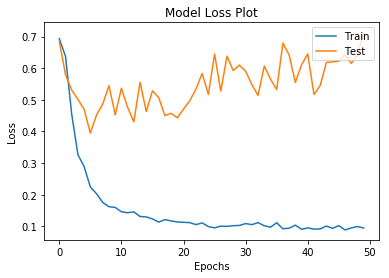

In [81]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(attention_history.history['loss'])
plt.plot(attention_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
att_model.save('attention_model.hdf5')

# Attention MODEL: Case 2 - Using Pretrained embedding

In [55]:
embeddings = dict()                                 ##read glove vector file
f = open('../glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [56]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [57]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
conv1 = Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=4)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 128, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model1=keras.Model(seq_input,output)


In [58]:
att_model1.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [59]:
attention_history=att_model1.fit(X_train, Y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/50
2334/2334 [==============================] - 13s 6ms/step - loss: 0.6708 - acc: 0.5754 - val_loss: 0.6466 - val_acc: 0.6385
Epoch 2/50
2334/2334 [==============================] - 9s 4ms/step - loss: 0.6119 - acc: 0.6710 - val_loss: 0.5851 - val_acc: 0.7115
Epoch 3/50
2334/2334 [==============================] - 9s 4ms/step - loss: 0.5337 - acc: 0.7391 - val_loss: 0.5598 - val_acc: 0.7308
Epoch 4/50
2334/2334 [==============================] - 8s 4ms/step - loss: 0.4688 - acc: 0.7768 - val_loss: 0.5409 - val_acc: 0.7654
Epoch 5/50
2334/2334 [==============================] - 9s 4ms/step - loss: 0.3910 - acc: 0.8269 - val_loss: 0.4809 - val_acc: 0.7731
Epoch 6/50
2334/2334 [==============================] - 9s 4ms/step - loss: 0.3604 - acc: 0.8368 - val_loss: 0.5939 - val_acc: 0.7577
Epoch 7/50
2334/2334 [==============================] - 9s 4ms/step - loss: 0.3386 - acc: 0.8565 - val_loss: 0.4864 - val_acc: 0.8192
Epoch 8/50
233

In [60]:
score = att_model1.evaluate(X_test,Y_test,verbose = 1)
score[1]

649/649 [==============================] - 1s 1ms/step


0.8705701079500842

# Hyperparameter Tuning

In [61]:
def model_attention1_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=2,units = 128,neurons = 20):
    
    seq_input = keras.Input(shape=(100,))
    e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
    conv1 = Conv1D(nb_filters,kernel_size,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
    pool = MaxPooling1D(pool_size)(conv1)
    dropout= Dropout(0.5)(pool)
    lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
    att=attention()(lstm1)
    dense1 = Dense(units = neurons, activation='relu', kernel_initializer='he_uniform')(att)
    output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
    model=keras.Model(seq_input,output) 
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [62]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5],
    'pool_size':[2,4]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................
Epoch 1/10
 - 8s - loss: 0.6897 - acc: 0.5333
Epoch 2/10
 - 4s - loss: 0.6723 - acc: 0.6148
Epoch 3/10
 - 4s - loss: 0.6320 - acc: 0.6541
Epoch 4/10
 - 4s - loss: 0.5920 - acc: 0.7021
Epoch 5/10
 - 4s - loss: 0.5700 - acc: 0.7143
Epoch 6/10
 - 4s - loss: 0.5414 - acc: 0.7461
Epoch 7/10
 - 4s - loss: 0.5328 - acc: 0.7478
Epoch 8/10
 - 4s - loss: 0.4933 - acc: 0.7744
Epoch 9/10
 - 4s - loss: 0.4718 - acc: 0.7953
Epoch 10/10
 - 4s - loss: 0.5074 - acc: 0.7600
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total=  55.1s
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.2s remaining:    0.0s


Epoch 1/10
 - 9s - loss: 0.6921 - acc: 0.5171
Epoch 2/10
 - 4s - loss: 0.6815 - acc: 0.6009
Epoch 3/10
 - 4s - loss: 0.6525 - acc: 0.6258
Epoch 4/10
 - 4s - loss: 0.6236 - acc: 0.6669
Epoch 5/10
 - 4s - loss: 0.5844 - acc: 0.7050
Epoch 6/10
 - 4s - loss: 0.5569 - acc: 0.7316
Epoch 7/10
 - 4s - loss: 0.5401 - acc: 0.7501
Epoch 8/10
 - 4s - loss: 0.5584 - acc: 0.7270
Epoch 9/10
 - 4s - loss: 0.5054 - acc: 0.7669
Epoch 10/10
 - 4s - loss: 0.4928 - acc: 0.7796
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total=  55.8s
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................
Epoch 1/10
 - 9s - loss: 0.6883 - acc: 0.5277
Epoch 2/10
 - 4s - loss: 0.6682 - acc: 0.5919
Epoch 3/10
 - 4s - loss: 0.6314 - acc: 0.6543
Epoch 4/10
 - 5s - loss: 0.6091 - acc: 0.6786
Epoch 5/10
 - 4s - loss: 0.5795 - acc: 0.7092
Epoch 6/10
 - 4s - loss: 0.5570 - acc: 0.7220
Epoch 7/10
 - 4s - loss: 0.5321 - acc: 0.7422
Epoch 8/10
 - 4s - loss: 0.5034 - acc: 0.7688
Epoch 9/10
 - 4s - loss: 0.49

Epoch 9/10
 - 5s - loss: 0.4678 - acc: 0.7936
Epoch 10/10
 - 5s - loss: 0.4589 - acc: 0.7861
[CV] ....... kernel_size=5, nb_filters=128, pool_size=2, total= 1.2min
[CV] kernel_size=5, nb_filters=128, pool_size=4 ......................
Epoch 1/10
 - 11s - loss: 0.6892 - acc: 0.5350
Epoch 2/10
 - 4s - loss: 0.6673 - acc: 0.5894
Epoch 3/10
 - 3s - loss: 0.6296 - acc: 0.6507
Epoch 4/10
 - 4s - loss: 0.5855 - acc: 0.6831
Epoch 5/10
 - 4s - loss: 0.5287 - acc: 0.7490
Epoch 6/10
 - 4s - loss: 0.5221 - acc: 0.7426
Epoch 7/10
 - 4s - loss: 0.4708 - acc: 0.7872
Epoch 8/10
 - 4s - loss: 0.4443 - acc: 0.7999
Epoch 9/10
 - 4s - loss: 0.4062 - acc: 0.8282
Epoch 10/10
 - 4s - loss: 0.4133 - acc: 0.8120
[CV] ....... kernel_size=5, nb_filters=128, pool_size=4, total=  59.7s
[CV] kernel_size=5, nb_filters=128, pool_size=4 ......................
Epoch 1/10
 - 12s - loss: 0.6895 - acc: 0.5512
Epoch 2/10
 - 4s - loss: 0.6561 - acc: 0.6258
Epoch 3/10
 - 4s - loss: 0.6006 - acc: 0.6865
Epoch 4/10
 - 4s - los

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 29.0min finished


Epoch 1/10
 - 19s - loss: 0.6733 - acc: 0.6002
Epoch 2/10
 - 8s - loss: 0.6214 - acc: 0.6611
Epoch 3/10
 - 8s - loss: 0.5714 - acc: 0.7032
Epoch 4/10
 - 8s - loss: 0.5075 - acc: 0.7629
Epoch 5/10
 - 8s - loss: 0.4538 - acc: 0.7949
Epoch 6/10
 - 8s - loss: 0.4294 - acc: 0.8072
Epoch 7/10
 - 8s - loss: 0.3743 - acc: 0.8412
Epoch 8/10
 - 8s - loss: 0.3490 - acc: 0.8570
Epoch 9/10
 - 8s - loss: 0.3071 - acc: 0.8705
Epoch 10/10
 - 8s - loss: 0.3046 - acc: 0.8786
Best accuracy:  0.766769468003084
Best parameters:  {'kernel_size': 5, 'nb_filters': 256, 'pool_size': 4}


In [63]:
param_grid = {
    'neurons':[10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] neurons=10 ......................................................


C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 19s - loss: 0.6908 - acc: 0.5228
Epoch 2/10
 - 8s - loss: 0.6766 - acc: 0.5523
Epoch 3/10
 - 8s - loss: 0.6487 - acc: 0.6131
Epoch 4/10
 - 8s - loss: 0.5989 - acc: 0.7039
Epoch 5/10
 - 8s - loss: 0.5516 - acc: 0.7178
Epoch 6/10
 - 8s - loss: 0.5266 - acc: 0.7501
Epoch 7/10
 - 8s - loss: 0.5132 - acc: 0.7611
Epoch 8/10
 - 9s - loss: 0.4723 - acc: 0.7872
Epoch 9/10
 - 8s - loss: 0.4464 - acc: 0.7993
Epoch 10/10
 - 8s - loss: 0.4239 - acc: 0.8236
[CV] ....................................... neurons=10, total= 1.9min
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


Epoch 1/10
 - 22s - loss: 0.6916 - acc: 0.5176
Epoch 2/10
 - 9s - loss: 0.6753 - acc: 0.5905
Epoch 3/10
 - 9s - loss: 0.6285 - acc: 0.6622
Epoch 4/10
 - 9s - loss: 0.5943 - acc: 0.6900
Epoch 5/10
 - 10s - loss: 0.5611 - acc: 0.7293
Epoch 6/10
 - 8s - loss: 0.5460 - acc: 0.7392
Epoch 7/10
 - 9s - loss: 0.5227 - acc: 0.7629
Epoch 8/10
 - 9s - loss: 0.5123 - acc: 0.7629
Epoch 9/10
 - 9s - loss: 0.4962 - acc: 0.7854
Epoch 10/10
 - 10s - loss: 0.4867 - acc: 0.7837
[CV] ....................................... neurons=10, total= 2.2min
[CV] neurons=10 ......................................................
Epoch 1/10
 - 23s - loss: 0.6871 - acc: 0.5410
Epoch 2/10
 - 10s - loss: 0.6559 - acc: 0.6295
Epoch 3/10
 - 9s - loss: 0.6157 - acc: 0.6653
Epoch 4/10
 - 9s - loss: 0.5767 - acc: 0.7075
Epoch 5/10
 - 9s - loss: 0.5472 - acc: 0.7347
Epoch 6/10
 - 9s - loss: 0.5248 - acc: 0.7399
Epoch 7/10
 - 8s - loss: 0.4606 - acc: 0.7896
Epoch 8/10
 - 8s - loss: 0.4585 - acc: 0.7890
Epoch 9/10
 - 8s - loss:

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 27.5min finished


Epoch 1/10
 - 33s - loss: 0.6811 - acc: 0.5486
Epoch 2/10
 - 17s - loss: 0.6259 - acc: 0.6550
Epoch 3/10
 - 17s - loss: 0.5775 - acc: 0.7140
Epoch 4/10
 - 17s - loss: 0.5303 - acc: 0.7413
Epoch 5/10
 - 17s - loss: 0.4868 - acc: 0.7745
Epoch 6/10
 - 17s - loss: 0.4252 - acc: 0.8076
Epoch 7/10
 - 17s - loss: 0.4152 - acc: 0.8126
Epoch 8/10
 - 17s - loss: 0.3463 - acc: 0.8497
Epoch 9/10
 - 17s - loss: 0.3327 - acc: 0.8585
Epoch 10/10
 - 17s - loss: 0.3501 - acc: 0.8504
Best accuracy:  0.7548188126445644
Best parameters:  {'neurons': 128}


In [64]:
param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.1 ................................................


C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 28s - loss: 0.6867 - acc: 0.5471
Epoch 2/10
 - 12s - loss: 0.6566 - acc: 0.6356
Epoch 3/10
 - 12s - loss: 0.6143 - acc: 0.6692
Epoch 4/10
 - 12s - loss: 0.5813 - acc: 0.7097
Epoch 5/10
 - 12s - loss: 0.5321 - acc: 0.7461
Epoch 6/10
 - 12s - loss: 0.4969 - acc: 0.7808
Epoch 7/10
 - 12s - loss: 0.4832 - acc: 0.7831
Epoch 8/10
 - 12s - loss: 0.4133 - acc: 0.8317
Epoch 9/10
 - 12s - loss: 0.4225 - acc: 0.8201
Epoch 10/10
 - 12s - loss: 0.3796 - acc: 0.8462
[CV] ................................. dropout_rate=0.1, total= 2.8min
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


Epoch 1/10
 - 32s - loss: 0.6858 - acc: 0.5795
Epoch 2/10
 - 13s - loss: 0.6542 - acc: 0.6489
Epoch 3/10
 - 13s - loss: 0.6025 - acc: 0.6888
Epoch 4/10
 - 13s - loss: 0.5792 - acc: 0.7073
Epoch 5/10
 - 13s - loss: 0.5520 - acc: 0.7293
Epoch 6/10
 - 13s - loss: 0.5273 - acc: 0.7548
Epoch 7/10
 - 13s - loss: 0.4932 - acc: 0.7652
Epoch 8/10
 - 13s - loss: 0.4551 - acc: 0.7947
Epoch 9/10
 - 13s - loss: 0.4480 - acc: 0.8057
Epoch 10/10
 - 13s - loss: 0.4584 - acc: 0.7964
[CV] ................................. dropout_rate=0.1, total= 3.0min
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
 - 29s - loss: 0.6895 - acc: 0.5572
Epoch 2/10
 - 13s - loss: 0.6578 - acc: 0.6249
Epoch 3/10
 - 13s - loss: 0.6142 - acc: 0.6699
Epoch 4/10
 - 13s - loss: 0.5928 - acc: 0.6855
Epoch 5/10
 - 13s - loss: 0.5505 - acc: 0.7283
Epoch 6/10
 - 13s - loss: 0.5092 - acc: 0.7549
Epoch 7/10
 - 13s - loss: 0.4735 - acc: 0.7763
Epoch 8/10
 - 13s - loss: 0.4378 - acc: 0.8023
Epoch 9/10


Epoch 6/10
 - 25s - loss: 0.5027 - acc: 0.7509
Epoch 7/10
 - 25s - loss: 0.4579 - acc: 0.7942
Epoch 8/10
 - 25s - loss: 0.4221 - acc: 0.8017
Epoch 9/10
 - 25s - loss: 0.3845 - acc: 0.8254
Epoch 10/10
 - 25s - loss: 0.3878 - acc: 0.8283
[CV] ................................. dropout_rate=0.5, total= 5.4min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 64.5min finished


Epoch 1/10
 - 62s - loss: 0.6889 - acc: 0.5455
Epoch 2/10
 - 38s - loss: 0.6435 - acc: 0.6423
Epoch 3/10
 - 38s - loss: 0.5872 - acc: 0.6974
Epoch 4/10
 - 38s - loss: 0.5429 - acc: 0.7367
Epoch 5/10
 - 38s - loss: 0.4841 - acc: 0.7803
Epoch 6/10
 - 38s - loss: 0.4549 - acc: 0.7961
Epoch 7/10
 - 38s - loss: 0.4038 - acc: 0.8196
Epoch 8/10
 - 38s - loss: 0.3988 - acc: 0.8234
Epoch 9/10
 - 38s - loss: 0.3405 - acc: 0.8531
Epoch 10/10
 - 38s - loss: 0.3351 - acc: 0.8593
Best accuracy:  0.7478797224363917
Best parameters:  {'dropout_rate': 0.5}


In [65]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] units=10 ........................................................
Epoch 1/10
 - 50s - loss: 0.6871 - acc: 0.5541
Epoch 2/10
 - 25s - loss: 0.6586 - acc: 0.6084
Epoch 3/10
 - 25s - loss: 0.6109 - acc: 0.6778
Epoch 4/10
 - 25s - loss: 0.5683 - acc: 0.7189
Epoch 5/10
 - 25s - loss: 0.5470 - acc: 0.7334
Epoch 6/10
 - 25s - loss: 0.5317 - acc: 0.7501
Epoch 7/10
 - 25s - loss: 0.4854 - acc: 0.7918
Epoch 8/10
 - 25s - loss: 0.4471 - acc: 0.8143
Epoch 9/10
 - 25s - loss: 0.4223 - acc: 0.8323
Epoch 10/10
 - 25s - loss: 0.4198 - acc: 0.8276
[CV] ......................................... units=10, total= 5.4min
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min remaining:    0.0s


Epoch 1/10
 - 54s - loss: 0.6861 - acc: 0.5448
Epoch 2/10
 - 26s - loss: 0.6495 - acc: 0.6287
Epoch 3/10
 - 26s - loss: 0.6062 - acc: 0.6900
Epoch 4/10
 - 26s - loss: 0.5557 - acc: 0.7276
Epoch 5/10
 - 26s - loss: 0.5280 - acc: 0.7449
Epoch 6/10
 - 26s - loss: 0.5117 - acc: 0.7582
Epoch 7/10
 - 25s - loss: 0.4877 - acc: 0.7808
Epoch 8/10
 - 25s - loss: 0.4448 - acc: 0.8097
Epoch 9/10
 - 25s - loss: 0.4173 - acc: 0.8265
Epoch 10/10
 - 25s - loss: 0.4059 - acc: 0.8265
[CV] ......................................... units=10, total= 5.7min
[CV] units=10 ........................................................
Epoch 1/10
 - 53s - loss: 0.6877 - acc: 0.5630
Epoch 2/10
 - 25s - loss: 0.6491 - acc: 0.6347
Epoch 3/10
 - 26s - loss: 0.6092 - acc: 0.6798
Epoch 4/10
 - 26s - loss: 0.5774 - acc: 0.7023
Epoch 5/10
 - 25s - loss: 0.5512 - acc: 0.7220
Epoch 6/10
 - 26s - loss: 0.4973 - acc: 0.7561
Epoch 7/10
 - 25s - loss: 0.4357 - acc: 0.8052
Epoch 8/10
 - 25s - loss: 0.4274 - acc: 0.8075
Epoch 9/10


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 105.1min finished


Epoch 1/10
 - 110s - loss: 0.6854 - acc: 0.5563
Epoch 2/10
 - 55s - loss: 0.6385 - acc: 0.6530
Epoch 3/10
 - 59s - loss: 0.5997 - acc: 0.6796
Epoch 4/10
 - 56s - loss: 0.5624 - acc: 0.7163
Epoch 5/10
 - 57s - loss: 0.5146 - acc: 0.7517
Epoch 6/10
 - 48s - loss: 0.4918 - acc: 0.7699
Epoch 7/10
 - 44s - loss: 0.4571 - acc: 0.7868
Epoch 8/10
 - 48s - loss: 0.4105 - acc: 0.8254
Epoch 9/10
 - 60s - loss: 0.3882 - acc: 0.8331
Epoch 10/10
 - 61s - loss: 0.3687 - acc: 0.8400
Best accuracy:  0.7606013878180417
Best parameters:  {'units': 20}


# MODEL with Optimised Parameters

In [67]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
conv1 = Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=4)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(20, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 128, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model2=keras.Model(seq_input,output)

In [68]:
att_model2.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [69]:
attention_history=att_model2.fit(X_train, Y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/50
2334/2334 [==============================] - 124s 53ms/step - loss: 0.6777 - acc: 0.5728 - val_loss: 0.6373 - val_acc: 0.6462
Epoch 2/50
2334/2334 [==============================] - 44s 19ms/step - loss: 0.6259 - acc: 0.6504 - val_loss: 0.6199 - val_acc: 0.6769
Epoch 3/50
2334/2334 [==============================] - 42s 18ms/step - loss: 0.5557 - acc: 0.7181 - val_loss: 0.5600 - val_acc: 0.7154
Epoch 4/50
2334/2334 [==============================] - 43s 19ms/step - loss: 0.4929 - acc: 0.7626 - val_loss: 0.5340 - val_acc: 0.7462
Epoch 5/50
2334/2334 [==============================] - 45s 19ms/step - loss: 0.4404 - acc: 0.8012 - val_loss: 0.4981 - val_acc: 0.7577
Epoch 6/50
2334/2334 [==============================] - 47s 20ms/step - loss: 0.3979 - acc: 0.8226 - val_loss: 0.5204 - val_acc: 0.7538
Epoch 7/50
2334/2334 [==============================] - 43s 18ms/step - loss: 0.3485 - acc: 0.8488 - val_loss: 0.5351 - val_acc: 0.7808


In [70]:
score = att_model2.evaluate(X_test,Y_test,verbose = 1)
score[1]

649/649 [==============================] - 3s 5ms/step


0.875192604098004

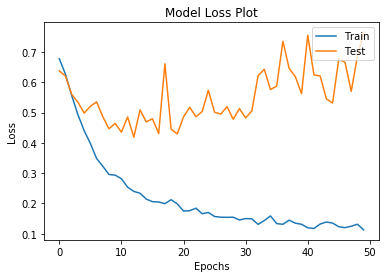

In [72]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(attention_history.history['loss'])
plt.plot(attention_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [73]:
att_model2.save('attention_pretrained.hdf5')